In [14]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import scipy
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable
from utility_functions.utils import *

In [21]:
def plot_dems(chrg_ec, demi, r, ethylene='None', n=2 ):
    end_ocv= chrg_ec[1]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    umolesdf=co2
    
    #convert ion current to moles of gas for baseline corrected data
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    
    cap=[]
    curr=[]
    
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        #print(index)
        if index < len(chrg_ec[1]):
            cap.append( new['Capacity/mA.h'].iloc[index])
            curr.append( new['I/mA'].iloc[index])
        elif index >= len(chrg_ec[1]):
            cap.append((umolesdf['time/min'].iloc[j]-end_ocv)/60*charge_i)
            

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    x= [0.0, chrg_ec[1]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[1]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[start_charge]
    total_moles = umoles_32 + umoles_2 + umoles_44

    print ('o2: '+ str(umoles_32) + str(umoles_32/total_moles*100) + '% ', 'h2: ' + str(umoles_2) + str(umoles_2/total_moles*100) + '%', str(umoles_44) + str(umoles_44/total_moles*100) + '%')
    factor= umoles_32/34
    factor=1
    
    if n==2:
        factor=1
    j1= 5
    j2=50
    ax2.plot(umolesdf['Capacity/mAh'][5:50] , 3.6*umolesdf['I/mA'][6:51]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
    ax2.plot(umolesdf['Capacity/mAh'][5:50], (umolesdf['32']/timediff/factor)[6:51] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')   
    ax2.plot(umolesdf['Capacity/mAh'][5:end_charge], (umolesdf['2']/timediff/factor)[5:end_charge] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
    #ax2.plot(umolesdf['Capacity/mAh'][:100], (umolesdf['28']/timediff/factor)[:100] , 'o:', alpha=0 , markersize=4, label = '28')
    ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['44']/timediff/factor)[j1:j2] , 'o:', markersize=4, label = 'CO$_2$', color = 'xkcd:irish green')
    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    if ethylene !='None':
        ax2.plot((umolesdf['Capacity/mAh'][18:90]), (umolesdf['c2h4']/timediff)[18:90] , 'o:', markersize=4, label = 'C$_2$H$_4$')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    
    ax2.legend(loc='upper center', bbox_to_anchor=[0.5, 0.85]) #, title= 'm/z value')
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue', markevery = 0.2)
    
    ax.set_ylim([1.6,4.8])
    rc['font.size'] = 12
#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)


    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)


    #     if n==1:
#         epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
#     else:
#         epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    
    return



In [16]:
def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    from scipy import optimize
    
    index = getnearpos(data['time/min'], end1/60)-1
    index2 = getnearpos(data['time/min'], start2)
    endocvtime= getnearpos(data['time/min'], start2+50)
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))


    #convert mass data into dataframe variables
    d = {'time/min' : data['time/min'][3:index], str(mz) : data[str(mz)][3:index] }
    d2 =  {'time/min' : data['time/min'][index2:-30], str(mz): data[str(mz)][index2:-30] }

    df = pd.DataFrame(d); df2 = pd.DataFrame(d2)
    newdf = pd.DataFrame()
    newdf = pd.concat([df,df2])
    row,col= data.shape

    def test_func(x, a):
        return (a * 1/x)

    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2+3]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2+3]-fullfile['time/min'].iloc[time1])
        return m
    
    def lin(fullfile,time,maz,cpstart,cpend):
        m= (maz.iloc[cpend]-maz.iloc[cpstart]) / (time.iloc[cpend]-time.iloc[cpstart])
        line=(m*(time-time.iloc[cpstart]) + maz.iloc[cpstart])
#         fullfile[str(mz)]= fullfile[str(mz)] - line
#         for i in range(0,index):
#             fullfile[str(mz)].iloc[i]=fullfile[str(mz)].iloc[i]-fullfile[str(mz)].iloc[i]
#         for i in range(index2,len(fullfile)):   
#             fullfile[str(mz)].iloc[i]=fullfile[str(mz)].iloc[i]-fullfile[str(mz)].iloc[i]
#         for i in range (index,index2):
#             fullfile[str(mz)].iloc[i]= fullfile[str(mz)].iloc[i] - line.iloc[i]
        return m #fullfile
    
    if mz == 2:
        m= slope( data, mz, index2+30, -10 )
        #correct= 2*10**-5*data['time/min'] + 0.028
        #correct = 5*10**-5*data['time/min'] +0.005 #na cp cycle1
        #correct = 1*10**-7*data['time/min'] +0.02 #na cp cycle2
        #correct = 1*10**-5*data['time/min'] +0.0173 #na CA cycle1
        #correct= -9.8617*10**-9*data['time/min']**2 + 1.2971*10**-5*data['time/min'] + 1.7803*10**-2
        correct=(m)*(data['time/min']- data['time/min'].iloc[index2+30]) + data[str(mz)].iloc[index2+30]
        

        
    elif mz == 32:
        m= slope( data, mz, index2+10, -10 )
        #correct = m * (data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]
        #correct = (m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]
        params, params_covariance = optimize.curve_fit(test_func, newdf['time/min'], newdf[str(32)], p0=[1])
        correct = params[0] * 1 / data['time/min']
        correct[0] = 5
        #correct = -4.0880*10**-6*data['time/min']+ 1.0521*10**-1
    elif mz == 44:
        m= slope( data, mz, index2+20, -10 )
        print('co2: ' + str(data['time/min'].iloc[index2+10]) + 'min')
        #correct = -2*10**-5*data['time/min'] + 0.029
        #correct = 1*10**-5*data['time/min'] + 0.0055 #na cp cycle1
        #correct = -5*10**-6*data['time/min'] + 0.015 #na cp cycle2
        #correct = -5*10**-6*data['time/min'] + 0.03 #na CA cycle1
        correct = m*(data['time/min']- data['time/min'].iloc[index2+20]) + data[str(mz)].iloc[index2+20]

    plt.plot(data['time/min'], correct, '.')
    
    data[str(mz)] = data[str(mz)]-correct
    #plt.ylim(0,2)
    
    #fullfile=correct
    #data[str(mz)] = data[str(mz)]-correct
    
    #co1= np.polyfit(np.log(newdf['time/min']), newdf[str(mz)], deg=1)
    #baselinecorr= co1[0]*np.log(data['time/min'])+col[1]
    #data[str(mz)] = data[str(mz)]-baselinecorr
    
    #recomment this for linear baseline
    #correct=lin( data, data['time/min'], data[str(mz)], index-1, index2 )
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()                            
    
    return (data)

In [17]:
#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    #m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955]
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    #new as of 6/29/20
    m = [1.463047028, 1.4379, 0.052035, 1.690955209, 0.7959230955] #6/29/20  1.646
    #inf_ar = 278.6590323 * demsdata['36']
    inf_ar = 286.5408 * demsdata['36']   #as of 6/2020
    
    names= ['2','26','28','32','34','36','44','45']
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
       
    
#     for i in range(len(names)):
#         demsdata[names[i]] = demsdata[names[i]] * vol / R / ( demsdata['temperature/C'] + 273 )

    return (demsdata) 


#plot chronoamperometric charge on DEMS
def plot_dems2(chrg_ec, demi, r, ethylene='None', n=1 , percent='None'):
    #oxyi= baselinecorr( demi, 36, chrg_ec[0]['time/s'].iloc[-1], time_min)
    end_ocv= chrg_ec[3]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    #convert ion current to moles of gas for baseline corrected data
    umolesdf = co2
    total_umoles= umolesdf['2']+umolesdf['32']+umolesdf['44']
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    print(timediff)
    chrg_ec[2]['Capacity/mA.h'] += chrg_ec[1]['Capacity/mA.h'].iloc[-1]
    
    if n==1:
        chrg_ec[3]['Capacity/mA.h'] += chrg_ec[2]['Capacity/mA.h'].iloc[-1]
    print(chrg_ec[3]['Capacity/mA.h'].iloc[-1])    
    charge_i= np.mean(chrg_ec[1]['I/mA'])  #normalize charge current by surface area (mA/cm2)
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    cap=[]
    curr=[]
    if n==1:
        new=pd.concat([chrg_ec[1], chrg_ec[2], chrg_ec[3]], sort=True)
    else:
        new=pd.concat([chrg_ec[1], chrg_ec[2]], sort=True)
        
    for j in range( len(umolesdf)):  
        index=getnearpos( new['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])
        #print( str(new['time/s'].iloc[index]/60) + ' and '+ str(umolesdf['time/min'].iloc[j]) )

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    
    x= [0.0, chrg_ec[2]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (7,5), facecolor='None')
    ax2=ax.twinx()
    start_charge = getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge = getnearpos(umolesdf['time/min'], chrg_ec[3]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[5]
    print (umoles_32, umoles_2, umoles_44)
    factor=1
    #ax2.plot(umolesdf['Capacity/mAh'][6:80] , 3.6*umolesdf['I/mA'][6:80]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
#     ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['32']/timediff/factor)[5:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['2']/timediff)[4:110] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['44']/timediff)[4:110] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    
    if percent=='on':
        ax2.plot(umolesdf['Capacity/mAh'][6:90] , (umolesdf['32']/total_umoles*100)[7:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:tangerine')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['2']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:burnt orange')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['44']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'CO$_2$', color='xkcd:maroon', alpha=0.9)
    else:
        ax2.plot(umolesdf['Capacity/mAh'][6:80] , 3.6*umolesdf['I/mA'][6:80]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
        ax2.plot(umolesdf['Capacity/mAh'][4:80], (umolesdf['32']/timediff/factor)[5:81] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
        ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['2']/timediff)[4:110] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
        ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['44']/timediff)[4:110] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    

    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)

    ax2.legend()
    #( bbox_to_anchor=(0.98, 0.55))
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    ax.plot(chrg_ec[2]['Capacity/mA.h'], chrg_ec[2]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    if n==1:
        ax.plot(chrg_ec[3]['Capacity/mA.h'], chrg_ec[3]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    

#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    
    if percent == 'on':
        ax2.set_ylabel('% of Gas Evolved', fontsize=20)
    ax.set_ylim([1.6,4.0])
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    if n==1:
        epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
    else:
        epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    #plt.title("Cycle " + str(r))
    return






co2: 442.70994min
5.086688826086956
0.9144054767158296
33.54984958122779 -7.328587810385263 -0.16376751832697645
umoles O2: 33.54984958122779
e per mol: 1.0169297220662188
co2: 178.29455min
5.073815725
0.5421214154598096
22.876514249471352 -0.02099684848602725 0.1896844292459418
umoles O2: 22.876514249471352
e per mol: 0.8841977644363344


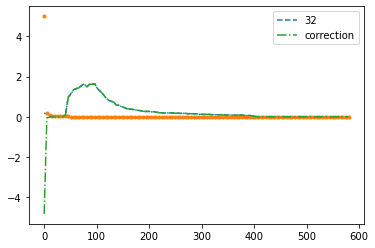

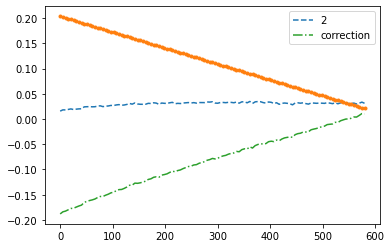

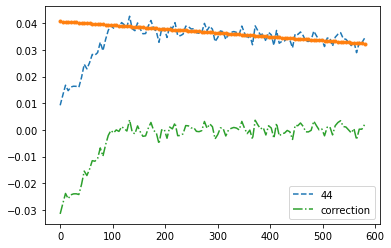

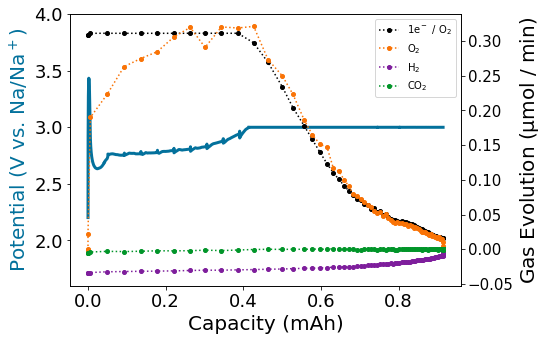

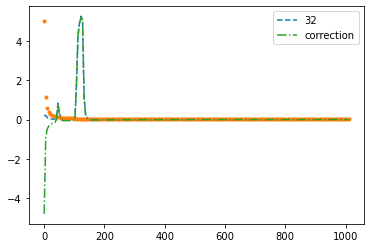

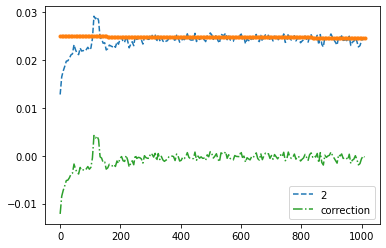

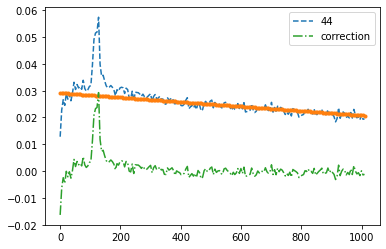

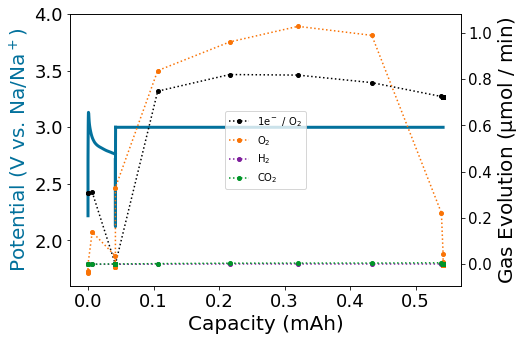

In [8]:
fold1='/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/'
CAgraphite1= find_charge(fold1)
CAgraphite2 = CAgraphite1[5:9]
chrg1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/200717_Na_MCMB0709_CA_dems_cell1_chrg_cy1_2020-07-17_13.55_25_ch1.txt')
chrg2= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/200717_Na_MCMB0709_CA_cell1_dems_chrg_cycle2_2020-07-18_15.10_17_ch1.txt')
plot_dems2(CAgraphite1, chrg1, r=1)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/200717_Na_MCMB0709_CA_dems_cell1_cycle1.png', transparent= True, dpi=800, bbox_inches='tight')


plot_dems2(CAgraphite2, chrg2, r=2)



co2: 402.09501min
5.086505739130434
0.8684651719199287
44.03784317047875 22.050203976111064 28.230944959256576
umoles O2: 44.03784317047875
e per mol: 0.7358157264666438
discharge current: -0.49978557953667957
1626.5 uL
o2 consumed: 39.18536667607091
e- per mol on discharge: 0.9518033527043585
discharge capacity: 0.9996050596237184


()

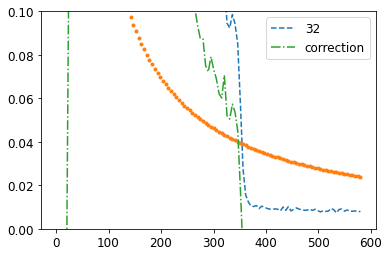

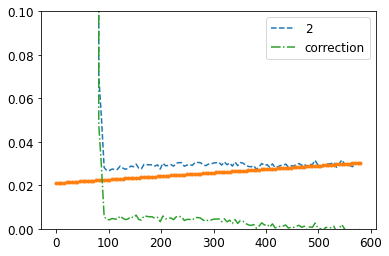

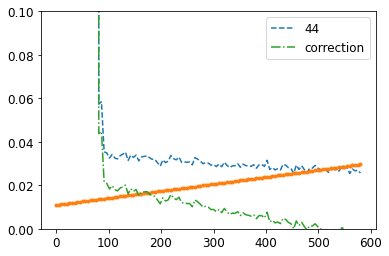

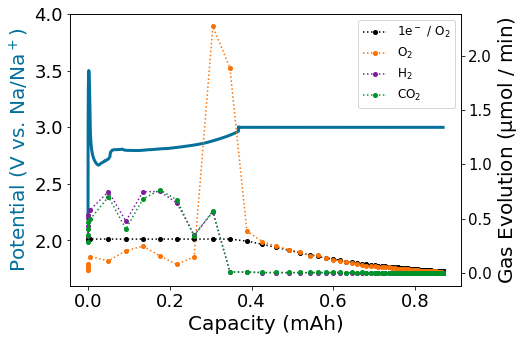

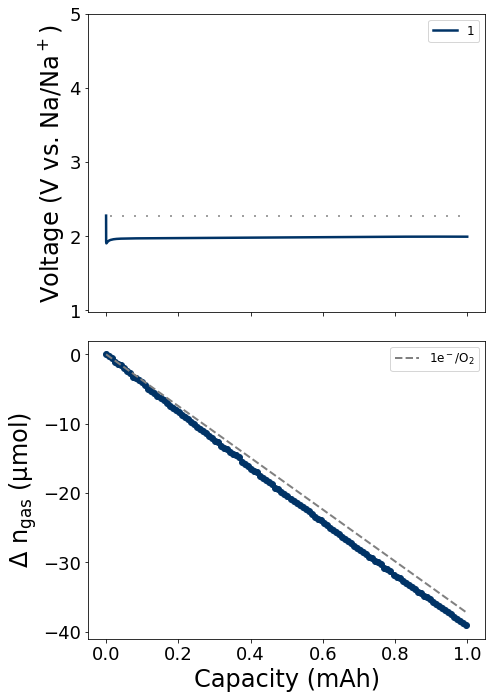

In [311]:
fold2='/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell2/'
cagraphitecell2= find_charge(fold2)
chrg1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell2/200717_Na_MCMB0709_CA_dems_cell2_chrg_cy1_2020-07-17_13.55_25_ch2.txt')

plot_dems2(cagraphitecell2, chrg1, r=1)


plot_discharge(na_cp1ec[9], cp_dis1,'dems1', 1, n=1)





discharge current: -0.4997463362043796
1626.5 uL
o2 consumed: 37.01787157129665
e- per mol on discharge: 1.0074542746771014
discharge capacity: 0.9995259841283164


()

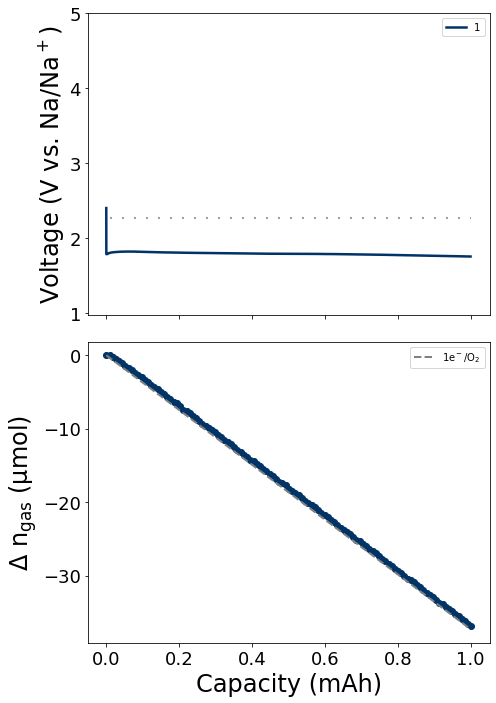

In [18]:

def plot_discharge(disch, press, channel, cyclenum, n=None, offset=0, eline=False):
    i=cyclenum
    colors=['#001933','#003366', '#0066CC', '#3399FF', '#99CCFF']
    n=1
    disc_i= np.mean(disch['I/mA']) #/(np.pi*0.6**2)
    print('discharge current: ' + str(disc_i))
    
    #find the final capacity reached on discharge in mAh
    cap=disch['Capacity/mA.h'].iloc[-1]

    x1=disch['Capacity/mA.h'] #/(np.pi*0.6**2)
    y1=disch['Ewe/V']
    endindex=-1      
    fig, (ax, ax2)= plt.subplots(2, sharex=True, figsize= (7,10)) 
    ax.plot(x1, y1, c=colors[i], linestyle='-', linewidth=2.5, label = str(i))
    ax.plot([0.01,cap],[2.27,2.27], c='#A0A0A0', linestyle=(0,(1,5)), linewidth=2)
    
    st1=disch['time/s'].iloc[0]
    end1=disch['time/s'].iloc[-1]
    
    #determine start and end indices in pressure df for discharge and charge
    st_p1 = getnearpos(press['time/s'],st1)
    end_p1 = getnearpos(press['time/s'],end1)
     
    temp = press['temperature/C']+273
    umoles = press['pressure/torr']/760*headspace(channel)/temp/0.082057
    print(str(headspace(channel)) + ' uL')
    umoles = umoles-umoles.iloc[st_p1]
    elec_oxy= x1.iloc[-1]*3.6/96485/umoles[end_p1]
    
    disch_cap=(press['time/s']-press['time/s'].iloc[st_p1])*-disc_i/3600
    
    x=[0,cap] #/(np.pi*0.6**2)]
    y=[0-offset,-cap*3.6/n/96485*10**6-offset]
    
    ax2.plot(disch_cap[st_p1:end_p1+1], (umoles)[st_p1:end_p1+1]+offset, 'o-', color= colors[i], linewidth=1.5, markersize=6, label='')
    ax2.plot(x, y,  c='grey', linestyle='--', linewidth= 2, label ='1e$^-$/O$_2$')

    print("o2 consumed: " + str(umoles[st_p1]-(umoles[end_p1+1] )))
    epermold = disch['Capacity/mA.h'].iloc[-1] * 3.6 / 96485 *10**6 / (umoles[st_p1]-(umoles[end_p1+1]))
    
    print("e- per mol on discharge: " + str(epermold))
    print('discharge capacity: ' + str(disch['Capacity/mA.h'].iloc[-1]))
    ax.tick_params(axis='both', which='major', labelsize=18); ax2.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylabel('Voltage (V vs. Na/Na$^+$)', fontsize=24); ax2.set_xlabel('Capacity (mAh)', fontsize=24)
    ax2.set_ylabel('$\Delta$ n$_{gas}$ ($\mu$mol)', fontsize=24); plt.tight_layout()
    ax.set_ylim([0.98,5])
    #ax.set_xlim()
    ax.legend()
    ax2.legend()
    return ()

dems1= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/')
dis1 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/200717_Na_MCMB0709_CA_dems_cell1_disch_cy1_Ch1__2020-07-17_10.55_23.txt')

plot_discharge(dems1[11], dis1, 'dems1', 1)

discharge current: -0.49978433153301893
1634.5 uL
o2 consumed: 36.91603665415508
e- per mol on discharge: 1.010314185463741
discharge capacity: 0.9996059205796984
discharge current: -0.4997925146778712
1634.5 uL
o2 consumed: 33.21870307570228
e- per mol on discharge: 0.9756957790596407
discharge capacity: 0.8686691522598267
co2: 402.09501min
5.086505739130434
0.8684651719199287
39.143034979031455 22.050203976111064 28.230944959256576
umoles O2: 39.143034979031455
e per mol: 0.8278289504599816
co2: 497.89480000000003min
5.073931625000001
0.9472119021746848
35.76642421301524 -0.07624222875165068 0.2800502904289936
umoles O2: 35.76642421301524
e per mol: 0.9881305415568354


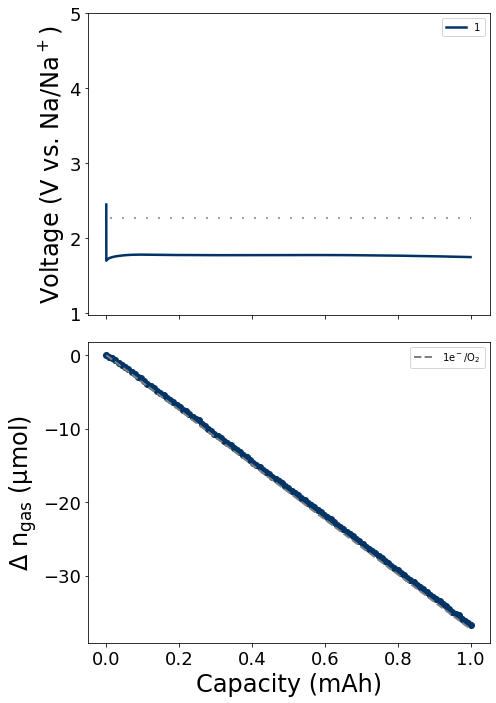

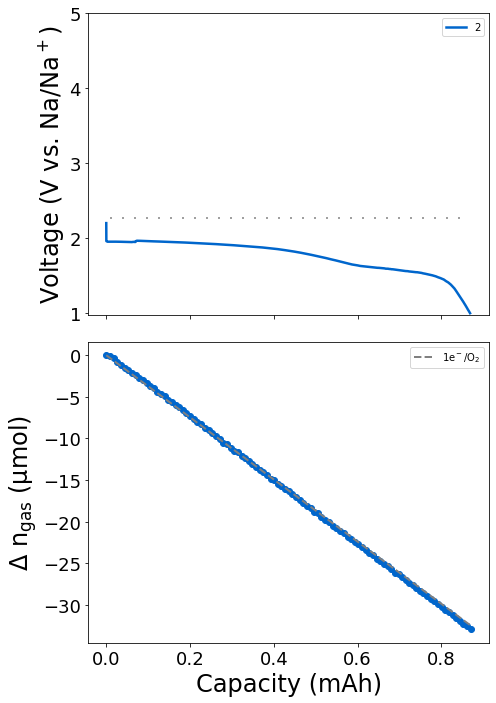

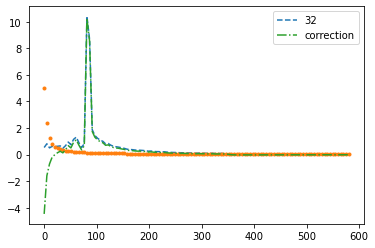

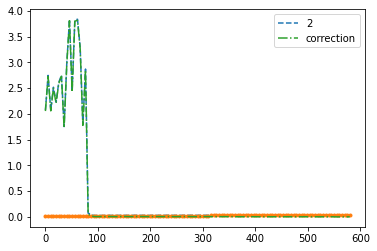

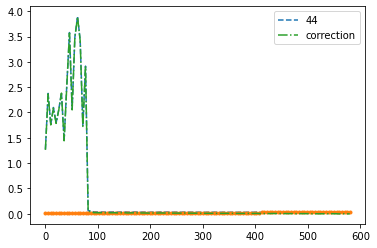

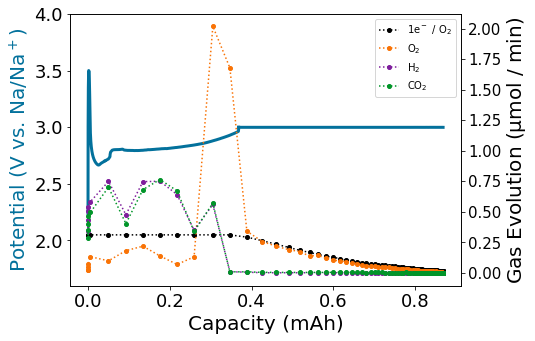

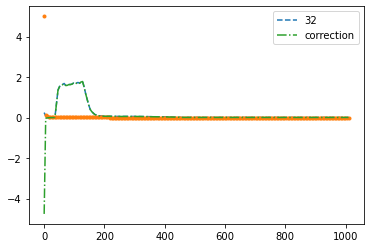

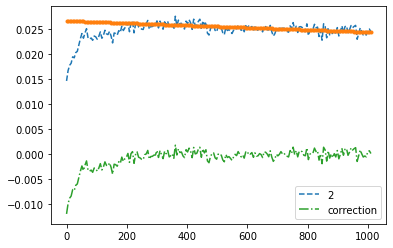

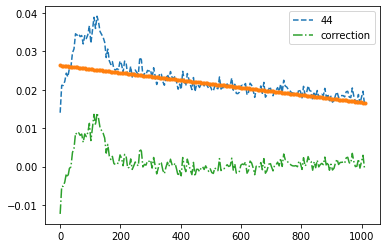

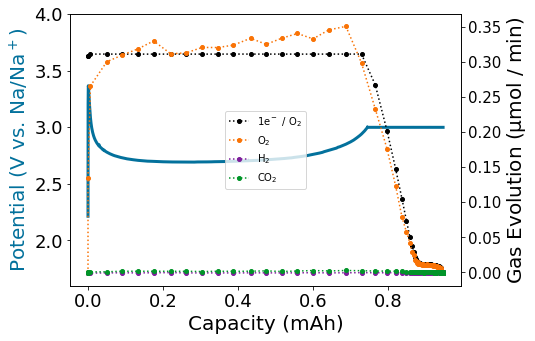

In [19]:
demscell2= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell2/')
dis2 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell2/200717_Na_MCMB0709_CA_dems_cell2_disch_cy1_Ch2__2020-07-17_10.55_42.txt')
dis2cy2= read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell1/200717_Na_MCMB0709_CA_dems_cell1_disch_cy2_Ch1__2020-07-18_12.25_28.txt')
plot_discharge(demscell2[11], dis2, 'dems2', 1)
plot_discharge(demscell2[14], dis2cy2, 'dems2', 2)

fold2='/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell2/'
cagraphitecell2= find_charge(fold2)
chrg2_ec = [demscell2[5],demscell2[6],demscell2[7], demscell2[8],demscell2[9] ]
chrg1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell2/200717_Na_MCMB0709_CA_dems_cell2_chrg_cy1_2020-07-17_13.55_25_ch2.txt')
chrg2= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200717_Na_MCMB0709_CA_dems_cell2/200717_Na_MCMB0709_CA_cell2_dems_chrg_cycle2_2020-07-18_15.10_17_ch2.txt')

plot_dems2(cagraphitecell2, chrg1, r=1)

plot_dems2(chrg2_ec, chrg2, r=1)








discharge current: -0.49978557953667957
1626.5 uL
o2 consumed: 39.18536667607091
e- per mol on discharge: 0.9518033527043585
discharge capacity: 0.9996050596237184


()

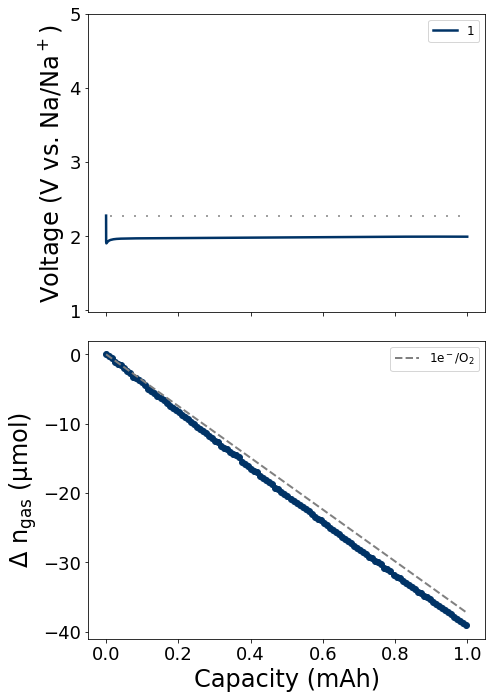

In [24]:
na_cp1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_chrg_cycle1_2018-09-28_16.40_19.txt')
na_cp1ec= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/')
cp_dis1 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_disch_cycle1_Ch1__2018-09-28_13.51_31.txt')

plot_discharge(na_cp1ec[9], cp_dis1,'dems1', 1, n=1)



discharge current: -0.49978854540094336
1634.5 uL
o2 consumed: 39.81703682768273
e- per mol on discharge: 0.9367070545205819
discharge capacity: 0.999608702129788
discharge current: -0.49977365228346465
1634.5 uL
o2 consumed: 18.734255314606543
e- per mol on discharge: 0.9664730079860856
discharge capacity: 0.4852700233459473
co2: 208.11291min
o2: 30.40852304261712696.99270096627536%  h2: 0.6226722988716621.9861098810948514% 0.32015660528322121.0211891526297803%
umoles O2: 30.408523042617126
e per mol: 1.227688553363278
co2: 147.68713min
o2: 15.9633699888076693.05498250483033%  h2: 0.87607621737711845.106895169258357% 0.315325692223808961.8381223259113173%
umoles O2: 15.96336998880766
e per mol: 1.1352133582392185


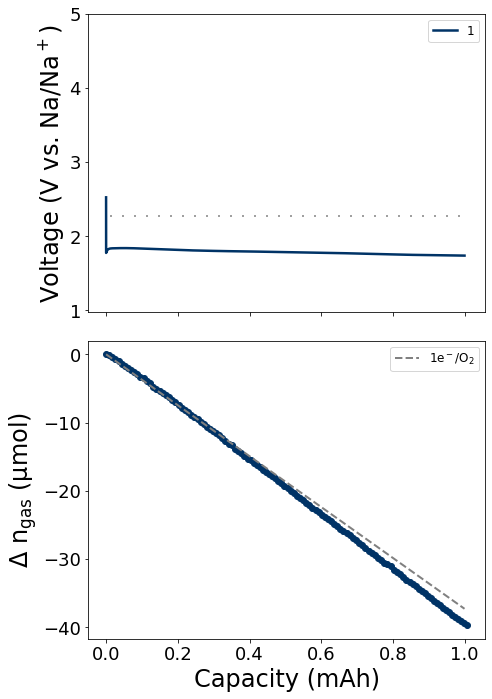

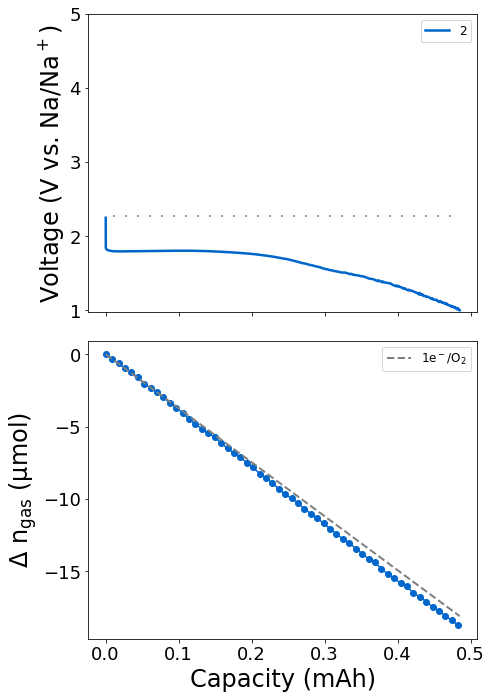

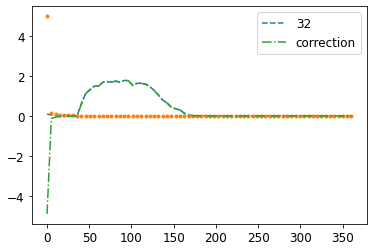

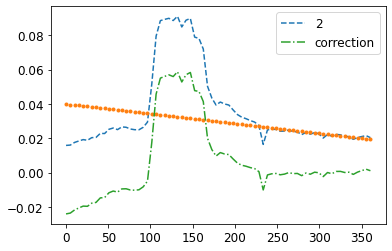

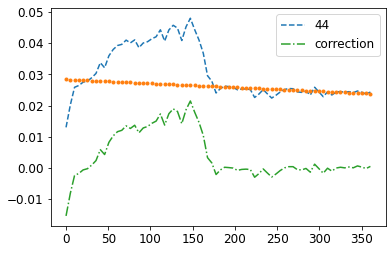

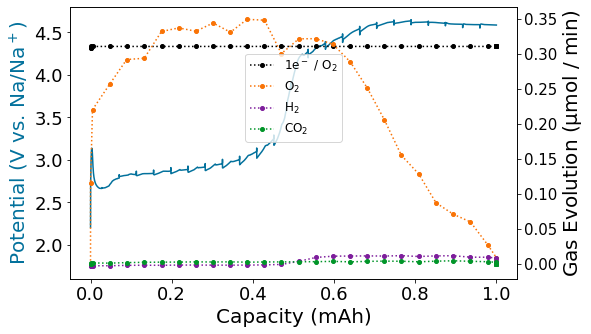

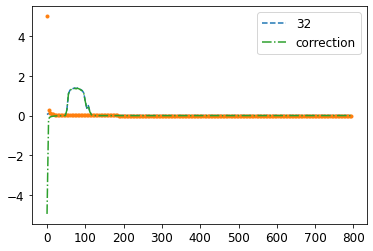

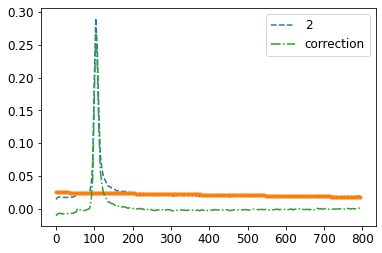

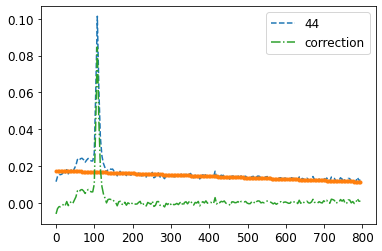

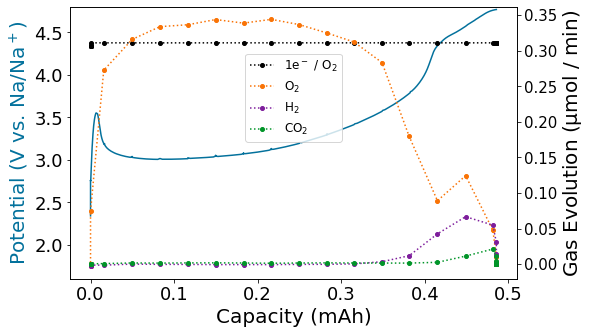

In [22]:
#Graphite 2 cycles DEMS charging with Constant Current (CP)
disch1 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200724_Na_MCMB0722_CP_cycling_cell2_dems/200724_Na_MCMB0722_CP_cycling_cell2_dish_cy1_Ch2__2020-07-24_10.16_27.txt')
disch2 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200724_Na_MCMB0722_CP_cycling_cell2_dems/200724_Na_MCMB0722_CP_cycling_cell2_disch_cy2_Ch2__2020-07-24_19.11_56.txt')
chrg1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200724_Na_MCMB0722_CP_cycling_cell2_dems/200724_Na_MCMB0722_CP_cycling_cell2_chrg_cycle1_2020-07-24_13.01_55_ch2.txt')
chrg2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200724_Na_MCMB0722_CP_cycling_cell2_dems/200724_Na_MCMB0722_CP_cycling_cell2_chrg_cycle2_2020-07-24_20.28_39.txt')
graphite_CC_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200724_Na_MCMB0722_CP_cycling_cell2_dems/')
demscy1 = graphite_CC_fold[0:3]
demscy2 = graphite_CC_fold[3:6]

plot_discharge(graphite_CC_fold[7], disch1,'dems2', 1, n=1)
plot_discharge(graphite_CC_fold[10], disch2,'dems2', 2, n=1)


plot_dems(demscy1, chrg1, 1, n=1)
plot_dems(demscy2, chrg2, 2, n=1)




In [ ]:

fig, (ax)= plt.subplots(1, sharex=True, figsize= (10,5)) 
ax2 = ax.twinx()

for i in range(45,60):
    ax.plot(chrg1['time/min'][2:], np.abs(chrg1[str(i)]/chrg1[str(i)].iloc[5])[2:], 'o-', label = str(i))
    
    #ax.plot(chrg1['time/min'], chrg1[str(32)], 'o-', label = str(32))
     
ax2.plot(graphite_CC_fold[0]['time/s']/60, graphite_CC_fold[0]['Ewe/V'], 'orange')
ax2.plot(graphite_CC_fold[1]['time/s']/60, graphite_CC_fold[1]['Ewe/V'], 'orange')
ax2.plot(graphite_CC_fold[2]['time/s']/60, graphite_CC_fold[2]['Ewe/V'], 'orange')
ax.legend()

n=[16,28, 32, 34]

discharge current: -0.49978557953667957
1626.5 uL
o2 consumed: 39.18536667607091
e- per mol on discharge: 0.9518033527043585
discharge capacity: 0.9996050596237184
discharge current: -0.49982395312000005
1626.5 uL
o2 consumed: 38.22892008900784
e- per mol on discharge: 0.9756820595765084
discharge capacity: 0.9996722804175484


IndexError: single positional indexer is out-of-bounds

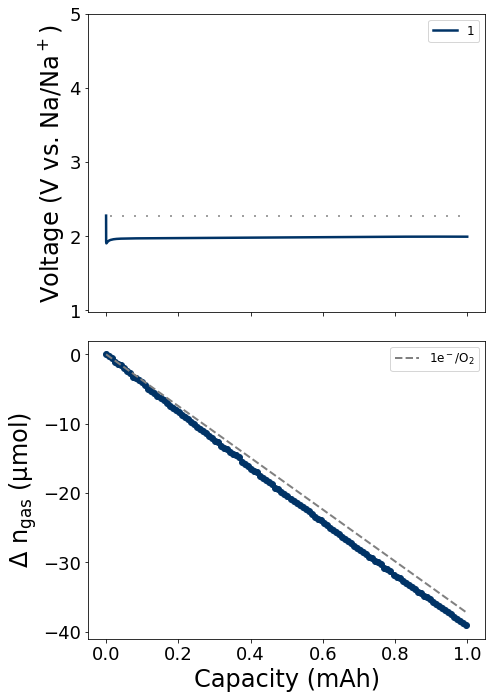

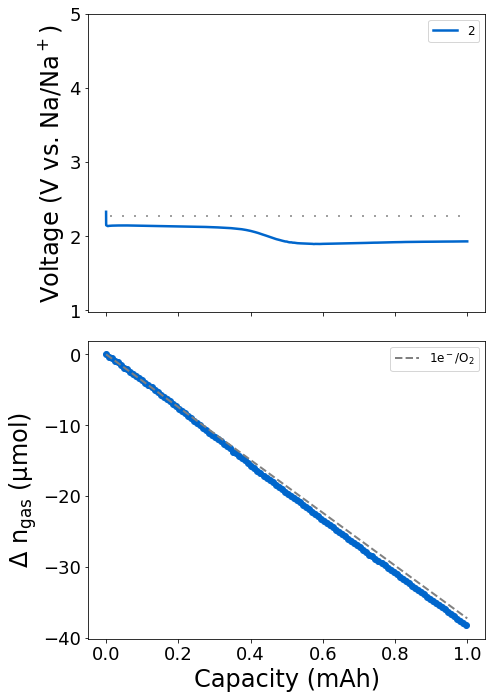

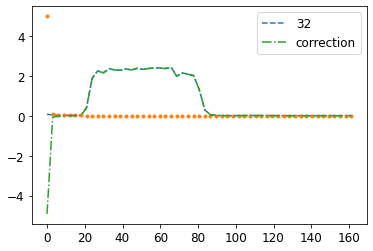

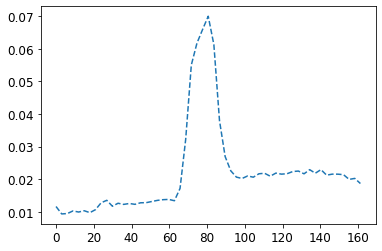

In [32]:
cp_p50 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/')
chrg1 = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/')
cp_p50_c1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_chrg_cycle1_2018-09-28_16.40_19.txt')
cp_p50_c2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_chrg_cycle2_2018-09-28_22.35_23.txt')
cp_p50_d1 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_disch_cycle1_Ch1__2018-09-28_13.51_31.txt')
cp_p50_d2 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180928_Na_chronopotent_cycling_2cycles_dems/180928_Na_chronopotent_cycling_2cycles_dems_disch_cycle2_Ch1__2018-09-28_19.39_47.txt')
plot_discharge(cp_p50[9], cp_p50_d1,'dems1', 1, n=1)
plot_discharge(cp_p50[14], cp_p50_d2,'dems1', 2, n=1)

plot_dems(chrg1, cp_p50_c1, 1, n=1)
#plot_dems(demscy2, chrg2, 2, n=1)


